 Importing PyTorch and setting up device-agnostic code	Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.
1. Get data	We're going to be using our own custom dataset of pizza, steak and sushi images.
2. Become one with the data (data preparation)	At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have.
3. Transforming data	Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to transform our images so they're ready to be used with a model.
4. Loading data with ImageFolder (option 1)	PyTorch has many in-built data loading functions for common types of data. ImageFolder is helpful if our images are in standard image classification format.
5. Loading image data with a custom Dataset	What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of torch.utils.data.Dataset.
6. Other forms of transforms (data augmentation)	Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of torchvision's in-built data augmentation functions.
7. Model 0: TinyVGG without data augmentation	By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model.
8. Exploring loss curves	Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is underfitting or overfitting.
9. Model 1: TinyVGG with data augmentation	By now, we've tried a model without, how about we try one with data augmentation?
10. Compare model results	Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance.
11. Making a prediction on a custom image	Our model is trained to on a dataset of biriyani, other images. In this section we'll cover how to use our trained model to predict on an image outside of our existing dataset.

# Before Starting What is Custom Datasets 

# Importing PyTorch and setting up device

In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.5.1+cu118'

# Setting CUDA insted od CPU 

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Collect Data 

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "food"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "food.zip", "wb") as f:
        request = requests.get("https://github.com/Suruj0001/Pytorch-Computer-Vision/blob/main/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "food.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

data\food directory exists.


# Preparing Data 

In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\food'.
There are 3 directories and 0 images in 'data\food\test'.
There are 0 directories and 50 images in 'data\food\test\biryani'.
There are 0 directories and 50 images in 'data\food\test\butter_chicken'.
There are 0 directories and 50 images in 'data\food\test\daal_puri'.
There are 3 directories and 0 images in 'data\food\train'.
There are 0 directories and 50 images in 'data\food\train\biryani'.
There are 0 directories and 50 images in 'data\food\train\butter_chicken'.
There are 0 directories and 50 images in 'data\food\train\daal_puri'.


In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/food/train'), WindowsPath('data/food/test'))

###  Visualize an image



Now in the spirit of the data explorer, it's time to *visualize, visualize, visualize!*

Let's write some code to:
 Get all of the image paths using [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) to find all of the files ending in `.jpg`. 
 Pick a random image path using Python's [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice).
 Get the image class name using [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent).
 And since we're working with images, we'll open the random image path using [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open) (PIL stands for Python Image Library).
 We'll then show the image and print some metadata.

Random image path: data\food\test\butter_chicken\15a368b1e9.jpg
Image class: butter_chicken
Image height: 225
Image width: 225


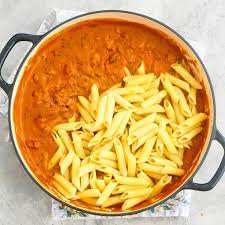

In [7]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

We can do the same with [`matplotlib.pyplot.imshow()`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html), except we have to convert the image to a NumPy array first.

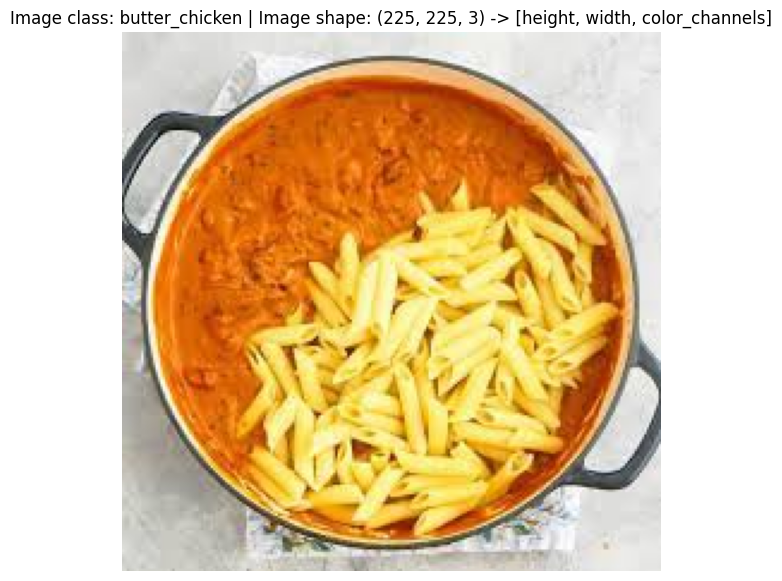

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [ ]:
## Transforming data 

Now what if we wanted to load our image data into PyTorch?

Before we can use our image data with PyTorch we need to:

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader` for short.

There are several different kinds of pre-built datasets and dataset loaders for PyTorch, depending on the problem you're working on. 

| **Problem space** | **Pre-built Datasets and Functions** |
| ----- | ----- |
| **Vision** | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) |
| **Audio** | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html) |
| **Text** | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) |
| **Recommendation system** | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html) |

Since we're working with a vision problem, we'll be looking at `torchvision.datasets` for our data loading functions as well as [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) for preparing our data.

Let's import some base libraries.

In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

###  Transforming data with `torchvision.transforms`

We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the `torchvision.transforms` module.

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for **data augmentation** (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes . 



In [10]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

Now we've got a composition of transforms, let's write a function to try them out on various images.

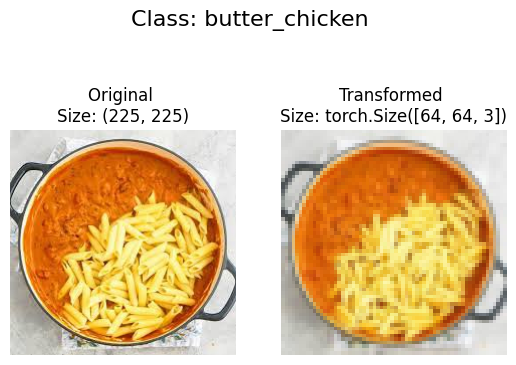

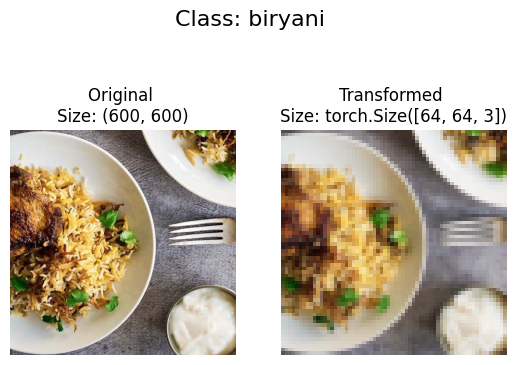

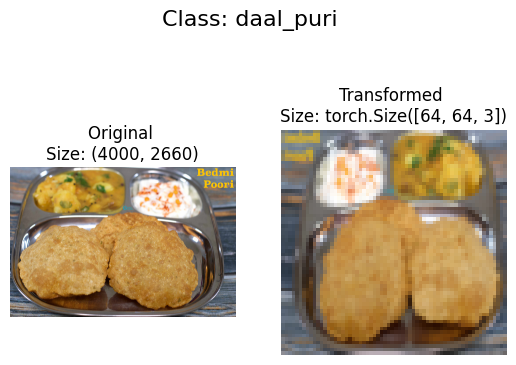

In [11]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

Nice!

We've now got a way to convert our images to tensors using `torchvision.transforms`.

We also manipulate their size and orientation if needed (some models prefer images of different sizes and shapes).

Generally, the larger the shape of the image, the more information a model can recover.

For example, an image of size `[256, 256, 3]` will have 16x more pixels than an image of size `[64, 64, 3]` (`(256*256*3)/(64*64*3)=16`).

However, the tradeoff is that more pixels requires more computations.

> **Exercise:** Try commenting out one of the transforms in `data_transform` and running the plotting function `plot_transformed_images()` again, what happens?

## . Option 1: Loading Image Data Using [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)

Alright, time to turn our image data into a `Dataset` capable of being used with PyTorch.



In [12]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 150
    Root location: data\food\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 150
    Root location: data\food\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


Beautiful!

It looks like PyTorch has registered our `Dataset`'s.

Let's inspect them by checking out the `classes` and `class_to_idx` attributes as well as the lengths of our training and test sets.

In [13]:
# Get class names as a list
class_names = train_data.classes
class_names

['biryani', 'butter_chicken', 'daal_puri']

In [14]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'biryani': 0, 'butter_chicken': 1, 'daal_puri': 2}

In [15]:
# Check the lengths
len(train_data), len(test_data)

(150, 150)

Nice! Looks like we'll be able to use these to reference for later.

How about our images and labels?

How do they look?

We can index on our `train_data` and `test_data` `Dataset`'s to find samples and their target labels.

In [16]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.8824, 0.8588, 0.8549,  ..., 0.1451, 0.1333, 0.1294],
         [0.8078, 0.5451, 0.4471,  ..., 0.3176, 0.1804, 0.1098],
         [0.9137, 0.7686, 0.7686,  ..., 0.4353, 0.4118, 0.2784],
         ...,
         [0.2431, 0.3333, 0.1765,  ..., 0.3529, 0.3451, 0.3725],
         [0.2471, 0.3373, 0.3059,  ..., 0.5216, 0.5216, 0.4902],
         [0.2235, 0.2431, 0.2157,  ..., 0.6039, 0.5451, 0.4784]],

        [[0.8784, 0.8667, 0.8784,  ..., 0.1294, 0.1137, 0.1098],
         [0.7961, 0.6157, 0.5490,  ..., 0.2980, 0.1647, 0.0902],
         [0.9059, 0.8000, 0.7922,  ..., 0.4039, 0.3882, 0.2588],
         ...,
         [0.1882, 0.2667, 0.1529,  ..., 0.3647, 0.3529, 0.3804],
         [0.2353, 0.3098, 0.2824,  ..., 0.5137, 0.5137, 0.4863],
         [0.1922, 0.2314, 0.2078,  ..., 0.5882, 0.5294, 0.4667]],

        [[0.8510, 0.8353, 0.8314,  ..., 0.1412, 0.1373, 0.1373],
         [0.7255, 0.4000, 0.2588,  ..., 0.3059, 0.1765, 0.1098],
         [0.8784, 0.7020, 0.6941,  ..., 0.40

Our images are now in the form of a tensor (with shape `[3, 64, 64]`) and the labels are in the form of an integer relating to a specific class (as referenced by the `class_to_idx` attribute).

How about we plot a single image tensor using `matplotlib`?

We'll first have to to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format `CHW` (color channels, height, width) but `matplotlib` prefers `HWC` (height, width, color channels).

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


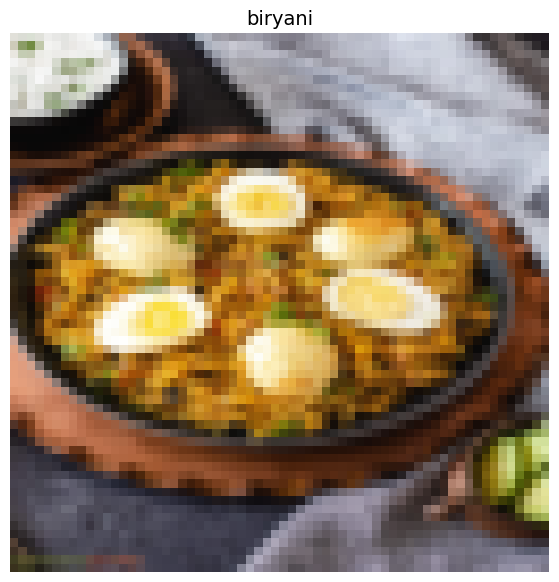

In [17]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

Notice the image is now more pixelated (less quality).

This is due to it being resized from `512x512` to `64x64` pixels.

The intuition here is that if you think the image is harder to recognize what's going on, chances are a model will find it harder to understand too.

Transforming Datasets into DataLoaders
Now that we have our datasets prepared, the next step is to convert them into DataLoader objects. This can be achieved using the torch.utils.data.DataLoader class.

The purpose of a DataLoader is to make a Dataset iterable, enabling efficient data batching, shuffling, and sampling during the training process. This functionality is crucial for feeding data to machine learning models in a structured manner.

In this case, we will configure the DataLoader with a batch_size of 1 and set num_workers to 1.

Understanding num_workers
The num_workers parameter specifies the number of subprocesses to use for data loading. By leveraging multiple subprocesses, PyTorch can parallelize the data-loading process, reducing potential bottlenecks during training.

The optimal value for num_workers often depends on your hardware. A common strategy is to match it to the number of available CPU cores on your machine, which can be determined using Python’s os.cpu_count(). This approach ensures the DataLoader can utilize the maximum available compute resources for efficient data preparation.

By fine-tuning parameters like batch_size and num_workers, you can optimize the data pipeline to suit your specific workload and hardware constraints, enhancing the overall training process.

In [18]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x25ef3be5f70>,
 <torch.utils.data.dataloader.DataLoader at 0x25eee1b8f50>)

Wonderful!

Now our data is iterable.

Let's try it out and check the shapes.

In [19]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


We could now use these `DataLoader`'s with a training and testing loop to train a model.

But before we do, let's look at another option to load images (or almost any other kind of data).

Implementing a Custom Dataset for Image Data
In scenarios where pre-built dataset utilities like torchvision.datasets.ImageFolder do not meet your specific requirements, creating a custom Dataset offers a flexible and powerful solution.

Advantages and Challenges of Custom Datasets
Advantages	Challenges
Enables the creation of datasets from virtually any data source.	Custom implementations may not always align with desired functionality.
Provides flexibility beyond the limitations of pre-built PyTorch dataset utilities.	Requires additional effort and code, which can introduce complexity or potential errors.
Subclassing torch.utils.data.Dataset
To demonstrate, we will construct a custom dataset class by subclassing PyTorch’s base Dataset class, torch.utils.data.Dataset. This approach allows us to replicate the functionality of utilities like ImageFolder while tailoring it to our unique dataset structure.

Required Modules
Before diving into implementation, let’s import the necessary libraries:

os: Facilitates interaction with the filesystem to manage directories where image data is stored.
pathlib: Simplifies the handling and manipulation of file paths for image files.
torch: Provides core functionalities for deep learning.
PIL.Image: Used to load and manipulate image files.
torch.utils.data.Dataset: The base class for implementing custom datasets.
torchvision.transforms: Offers utilities to preprocess and transform images into tensors.
typing: Enhances code clarity by adding type hints.
Note
This approach can be customized to accommodate your specific dataset requirements. The key is designing a structured pipeline that loads your data in the desired format efficiently and effectively.

In [20]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

Remember how our instances of `torchvision.datasets.ImageFolder()` allowed us to use the `classes` and `class_to_idx` attributes?

In [21]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['biryani', 'butter_chicken', 'daal_puri'],
 {'biryani': 0, 'butter_chicken': 1, 'daal_puri': 2})

Creating a Helper Function to Extract Class Names
To efficiently handle image classification datasets, we need a utility function to extract class names and map them to numerical indices. This function will traverse a target directory, ensuring the dataset adheres to the standard image classification structure, and return:

A list of class names.
A dictionary mapping each class name to its corresponding numerical index.
Implementation Plan
Extract Class Names: Use Python’s os.scandir() to traverse the directory and identify class names. Each subdirectory in the target directory represents a class.
Validate Directory Structure: Raise an error if no subdirectories (class names) are found, as this likely indicates an issue with the dataset's organization.
Create Mappings: Convert the extracted class names into a dictionary, where each class is assigned a unique numerical index.
Example of Directory Traversal
Before implementing the complete function, here’s a simple demonstration of step 1, which involves traversing the target directory to extract subdirectory names.

In [22]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data\food\train
Class names found: ['biryani', 'butter_chicken', 'daal_puri']


Excellent!

How about we turn it into a full function?

In [23]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    # 1. Get the class names by scanning the target directory
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    
    # 2. Raise an error if class names not found
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

Looking good!

Now let's test out our `find_classes()` function.

In [24]:
find_classes(train_dir)

(['biryani', 'butter_chicken', 'daal_puri'],
 {'biryani': 0, 'butter_chicken': 1, 'daal_puri': 2})

Woohoo! Looking good!

Building a Custom Dataset to Mimic ImageFolder
To enhance our understanding of PyTorch’s dataset framework and enable flexibility in handling unique data structures, we will create a custom Dataset that replicates the functionality of torchvision.datasets.ImageFolder.

This implementation will help us grasp the essential components of a custom Dataset while also serving as a template for building datasets tailored to specific use cases.

Implementation Overview
Subclass torch.utils.data.Dataset

The base class for all PyTorch datasets, this allows us to define custom data loading behavior.
Initialize the Dataset

Include the targ_dir parameter to specify the target directory containing the dataset.
Include the transform parameter to allow for optional transformations (e.g., resizing, normalization).
Define Key Attributes

paths: Store the file paths of all images in the target directory.
transform: Store any transformations to be applied to the images.
classes and class_to_idx: Use a helper function (e.g., find_classes()) to extract class names and map them to numerical indices.
Implement an Image Loader

Create a helper function to load images from file, utilizing either PIL.Image or torchvision.io.
Overwrite __len__

Return the number of samples in the dataset. This enables calling len(dataset) to retrieve the dataset size.
Overwrite __getitem__

Define how to fetch a single sample (image and label) given an index. This is a mandatory method for any custom dataset.

In [25]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

Woah! A whole bunch of code to load in our images.

This is one of the downsides of creating your own custom `Dataset`'s.

However, now we've written it once, we could move it into a `.py` file such as `data_loader.py` along with some other helpful data functions and reuse it later on. 

Before we test out our new `ImageFolderCustom` class, let's create some transforms to prepare our images.

In [26]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Now comes the moment of truth!

Let's turn our training images (contained in `train_dir`) and our testing images (contained in `test_dir`) into `Dataset`'s using our own `ImageFolderCustom` class.

In [27]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir, 
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, 
                                     transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x25ef3cc4bf0>,
 <__main__.ImageFolderCustom at 0x25ef3d00260>)

Hmm... no errors, did it work?

Let's try calling `len()` on our new `Dataset`'s and find the `classes` and `class_to_idx` attributes.

In [28]:
len(train_data_custom), len(test_data_custom)

(150, 150)

In [29]:
train_data_custom.classes

['biryani', 'butter_chicken', 'daal_puri']

In [30]:
train_data_custom.class_to_idx

{'biryani': 0, 'butter_chicken': 1, 'daal_puri': 2}

`len(test_data_custom) == len(test_data)` and `len(test_data_custom) == len(test_data)` Yes!!!

It looks like it worked.

We could check for equality with the `Dataset`'s made by the `torchvision.datasets.ImageFolder()` class too. 

In [31]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


Ho ho!

Look at us go!

Three `True`'s!

You can't get much better than that.

How about we take it up a notch and plot some random images to test our `__getitem__` override? 

Creating a Function to Visualize Random Images from a Dataset
Data visualization is a crucial step in exploring and understanding your dataset. To facilitate this, we’ll implement a helper function, display_random_images, designed to randomly sample and display images from a PyTorch Dataset.

Functionality Overview
The display_random_images function will:

Accept Input Parameters

Dataset: The dataset containing the images to visualize.
Classes: A list of class names corresponding to the dataset's labels.
Number of Images (n): The number of random images to display (with a maximum limit of 10 to maintain clarity).
Random Seed: An optional parameter for reproducibility.
Set a Random Seed

If a seed is provided, it will be used to ensure the same random samples are selected across runs.
Select Random Indices

Use Python’s random.sample() to generate a list of random indices from the dataset.
Prepare the Plot

Initialize a matplotlib figure to display the selected images.
Loop Through Random Indices

Retrieve and preprocess each image and label from the dataset.
Ensure the images are in HWC (height, width, color channels) format for proper visualization.
Plot each image with its corresponding class label.
Cap the Display Limit

Enforce a maximum of 10 images to prevent overly cluttered displays.


In [32]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

What a good looking function!

Let's test it out first with the `Dataset` we created with `torchvision.datasets.ImageFolder()`.

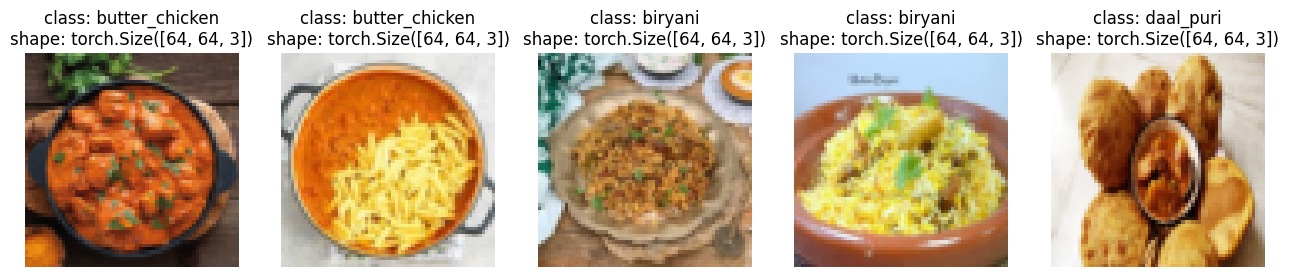

In [33]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data, 
                      n=5, 
                      classes=class_names,
                      seed=None)

And now with the `Dataset` we created with our own `ImageFolderCustom`.

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


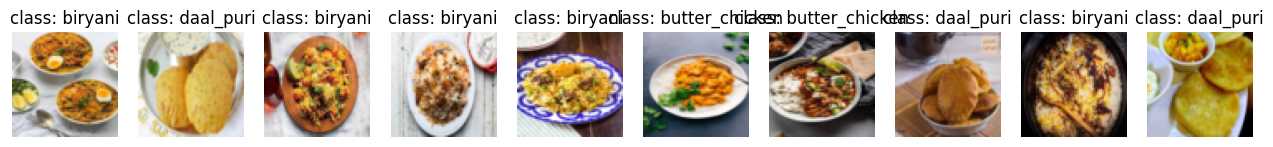

In [34]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom, 
                      n=12, 
                      classes=class_names,
                      seed=None) # Try setting the seed for reproducible images

Nice!!!

Looks like our `ImageFolderCustom` is working just as we'd like it to.

###  Turn custom loaded images into `DataLoader`'s 

We've got a way to turn our raw images into `Dataset`'s (features mapped to labels or `X`'s mapped to `y`'s) through our `ImageFolderCustom` class.

Now how could we turn our custom `Dataset`'s into `DataLoader`'s?

If you guessed by using `torch.utils.data.DataLoader()`, you'd be right!

Because our custom `Dataset`'s subclass `torch.utils.data.Dataset`, we can use them directly with `torch.utils.data.DataLoader()`.

And we can do using very similar steps to before except this time we'll be using our custom created `Dataset`'s.

In [35]:
# Turn train and test custom Dataset's into DataLoader's
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, # use custom created train Dataset
                                     batch_size=1, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader_custom = DataLoader(dataset=test_data_custom, # use custom created test Dataset
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x25ef3d9f170>,
 <torch.utils.data.dataloader.DataLoader at 0x25ef3c48860>)

Do the shapes of the samples look the same?

In [36]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


They sure do!

Let's now take a lot at some other forms of data transforms.

Exploring Data Augmentation with PyTorch Transforms
Data augmentation is a powerful technique in machine learning, particularly in computer vision, to improve model robustness and generalization. By applying transformations to images, we artificially increase the diversity of the training dataset, enabling models to learn more generalized patterns that perform well on unseen data.

What Are Transforms?
Transforms are operations that alter images in various ways, such as:

Converting images to tensors (e.g., transforms.ToTensor()).
Resizing or cropping images.
Randomly rotating, flipping, or erasing portions of images.
These operations can be applied during the data preprocessing stage and are available in the torchvision.transforms module.

Data Augmentation
Data augmentation introduces variations into the training data by applying random transformations. This process increases the effective size of the dataset without collecting additional data, which can lead to better generalization by teaching the model to handle variations it may encounter during inference.

Examples of augmentation include:

Random cropping or flipping.
Adjusting brightness, contrast, or saturation.
Random erasure of parts of an image.
Illustration of Augmentation Techniques
PyTorch provides an excellent overview of available transforms in its Illustration of Transforms example. These examples demonstrate how different augmentations can be applied to images.

Randomized Transforms for Improved Performance
Research indicates that random augmentation strategies, such as transforms.RandAugment() and transforms.TrivialAugmentWide(), often outperform manually selected augmentation pipelines. The key idea behind these methods is simplicity:

TrivialAugment applies a set of predefined transforms to an image.
The selection of transforms, their application order, and their magnitude are randomized within specified ranges.
Higher magnitudes correspond to more intense transformations, ensuring diverse variations.
By embracing randomness, these methods reduce the need for extensive manual tuning, making them an efficient choice for many applications.



In [37]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense 
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

> **Note:** You usually don't perform data augmentation on the test set. The idea of data augmentation is to to *artificially* increase the diversity of the training set to better predict on the testing set. 
>
> However, you do need to make sure your test set images are transformed to tensors. We size the test images to the same size as our training images too, however, inference can be done on different size images if necessary (though this may alter performance).

Beautiful, now we've got a training transform (with data augmentation) and test transform (without data augmentation).

Let's test our data augmentation out!

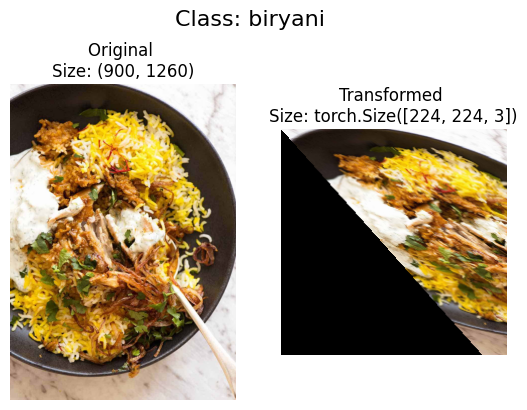

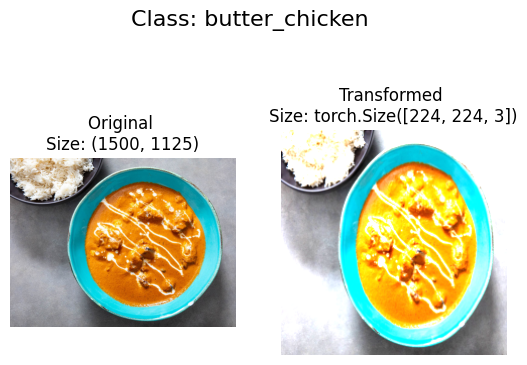

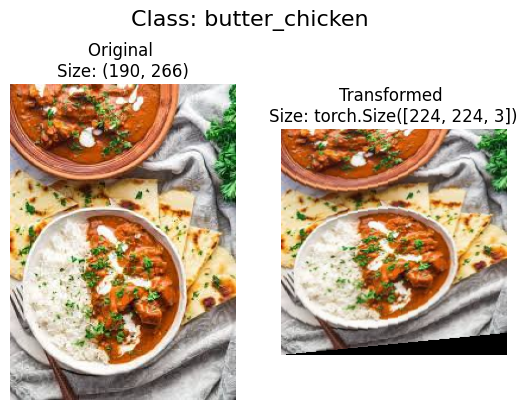

In [38]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

Try running the cell above a few times and seeing how the original image changes as it goes through the transform.

Building Model 0: TinyVGG Without Data Augmentation
With our data successfully transformed from images into tensors, we’re ready to design and train a computer vision model. The goal is to classify images into one of three categories: pizza, steak, or sushi.

Initial Approach: Minimal Transformations
To start, we will keep our data preprocessing straightforward. The only transformations applied will be:

Resizing images to a uniform shape of (64, 64).
Converting the resized images into tensors suitable for PyTorch.
This minimal preprocessing allows us to establish a baseline for model performance without the influence of data augmentation. By beginning with this simpler approach, we can better assess the effectiveness of augmentation techniques in subsequent iterations.

Model Architecture: TinyVGG
For this task, we’ll implement a compact convolutional neural network (CNN) inspired by the TinyVGG architecture. TinyVGG is a simplified variant of the well-known VGG architecture, designed to be lightweight while retaining strong performance for small-scale image classification tasks.

This initial model will serve as our baseline, providing a reference point for future improvements, such as the introduction of data augmentation or more complex architectures.

Let’s proceed with implementing the model and training it on the preprocessed dataset.








###  Creating transforms and loading data for Model 0

In [39]:
# Create simple transform
simple_transform = transforms.Compose([ 
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

Excellent, now we've got a simple transform, let's:
1. Load the data, turning each of our training and test folders first into a `Dataset` with `torchvision.datasets.ImageFolder()` 
2. Then into a `DataLoader` using `torch.utils.data.DataLoader()`.
    * We'll set the `batch_size=32` and `num_workers` to as many CPUs on our machine (this will depend on what machine you're using).

In [40]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 12 workers.


(<torch.utils.data.dataloader.DataLoader at 0x25e80b827e0>,
 <torch.utils.data.dataloader.DataLoader at 0x25e80b82990>)

`DataLoader`'s created! 

Let's build a model.

###  Create TinyVGG model class

In [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/#7-model-2-building-a-convolutional-neural-network-cnn), we used the TinyVGG model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

Let's recreate the same model, except this time we'll be using color images instead of grayscale (`in_channels=3` instead of `in_channels=1` for RGB pixels). 

In [41]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

> **Note:** One of the ways to speed up deep learning models computing on a GPU is to leverage **operator fusion**.
>
> This means in the `forward()` method in our model above, instead of calling a layer block and reassigning `x` every time, we call each block in succession (see the final line of the `forward()` method in the model above for an example).
>
> This saves the time spent reassigning `x` (memory heavy) and focuses on only computing on `x`.
> 
> See [*Making Deep Learning Go Brrrr From First Principles*](https://horace.io/brrr_intro.html) by Horace He for more ways on how to speed up machine learning models.

Now that's a nice looking model!

How about we test it out with a forward pass on a single image?



###  Try a forward pass on a single image (to test the model)

A good way to test a model is to do a forward pass on a single piece of data.

It's also handy way to test the input and output shapes of our different layers.

To do a forward pass on a single image, let's:
1. Get a batch of images and labels from the `DataLoader`.
2. Get a single image from the batch and `unsqueeze()` the image so it has a batch size of `1` (so its shape fits the model).
3. Perform inference on a single image (making sure to send the image to the target `device`).
4. Print out what's happening and convert the model's raw output logits to prediction probabilities with `torch.softmax()` (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with `torch.argmax()`.

In [42]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 64, 64])

Output logits:
tensor([[0.0684, 0.0633, 0.0423]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3368, 0.3351, 0.3281]], device='cuda:0')

Output prediction label:
tensor([0], device='cuda:0')

Actual label:
2


Wonderful, it looks like our model is outputting what we'd expect it to output.

You can run the cell above a few times and each time have a different image be predicted on.

And you'll probably notice the predictions are often wrong.

This is to be expected because the model hasn't been trained yet and it's essentially guessing using random weights.

### Use `torchinfo` to get an idea of the shapes going through our model

Printing out our model with `print(model)` gives us an idea of what's going on with our model.

And we can print out the shapes of our data throughout the `forward()` method.

However, a helpful way to get information from our model is to use [`torchinfo`](https://github.com/TylerYep/torchinfo).

`torchinfo` comes with a `summary()` method that takes a PyTorch model as well as an `input_shape` and returns what happens as a tensor moves through your model.

> **Note:** If you're using Google Colab, you'll need to install `torchinfo`.

In [43]:
# Install torchinfo if it's not available, import it if it is
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

Nice! 

The output of `torchinfo.summary()` gives us a whole bunch of information about our model.

Such as `Total params`, the total number of parameters in our model, the `Estimated Total Size (MB)` which is the size of our model.

You can also see the change in input and output shapes as data of a certain `input_size` moves through our model.

Right now, our parameter numbers and total model size is low. 

This because we're starting with a small model.

And if we need to increase its size later, we can.

###  Create train & test loop functions 

We've got data and we've got a model.

Now let's make some training and test loop functions to train our model on the training data and evaluate our model on the testing data.

And to make sure we can use these the training and testing loops again, we'll functionize them.

Specifically, we're going to make three functions:
1. `train_step()` - takes in a model, a `DataLoader`, a loss function and an optimizer and trains the model on the `DataLoader`.
2. `test_step()` - takes in a model, a `DataLoader` and a loss function and evaluates the model on the `DataLoader`.
3. `train()` - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

> **Note:** We covered the steps in a PyTorch opimization loop in [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/#creating-an-optimization-loop-in-pytorch), as well as the[ Unofficial PyTorch Optimization Loop Song](https://youtu.be/Nutpusq_AFw) and we've built similar functions in [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/#62-functionizing-training-and-test-loops).

Let's start by building `train_step()`.

Because we're dealing with batches in the `DataLoader`'s, we'll accumulate the model loss and accuracy values during training (by adding them up for each batch) and then adjust them at the end before we return them.

In [44]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

Woohoo! `train_step()` function done.

Now let's do the same for the `test_step()` function.

The main difference here will be the `test_step()` won't take in an optimizer and therefore won't perform gradient descent.

But since we'll be doing inference, we'll make sure to turn on the `torch.inference_mode()` context manager for making predictions.

In [45]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

Excellent!



### Creating a `train()` function to combine `train_step()` and `test_step()`

Now we need a way to put our `train_step()` and `test_step()` functions together.

To do so, we'll package them up in a `train()` function.

This function will train the model as well as evaluate it.

Specificially, it'll:
1. Take in a model, a `DataLoader` for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for `train_loss`, `train_acc`, `test_loss` and `test_acc` values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metrics each epoch.
6. Return the filled

To keep track of the number of epochs we've been through, let's import `tqdm` from `tqdm.auto` ([`tqdm`](https://github.com/tqdm/tqdm) is one of the most popular progress bar libraries for Python and `tqdm.auto` automatically decides what kind of progress bar is best for your computing environment, e.g. Jupyter Notebook vs. Python script).

In [46]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

###  Train and Evaluate Model 0

Alright, alright, alright we've got all of the ingredients we need to train and evaluate our model.

Time to put our `TinyVGG` model, `DataLoader`'s and `train()` function together to see if we can build a model capable of discerning between pizza, steak and sushi!

Let's recreate `model_0` (we don't need to but we will for completeness) then call our `train()` function passing in the necessary parameters.

To keep our experiments quick, we'll train our model for **5 epochs** (though you could increase this if you want).

As for an **optimizer** and **loss function**, we'll use `torch.nn.CrossEntropyLoss()` (since we're working with multi-class classification data) and `torch.optim.Adam()` with a learning rate of `1e-3` respecitvely.

To see how long things take, we'll import Python's [`timeit.default_timer()`](https://docs.python.org/3/library/timeit.html#timeit.default_timer) method to calculate the training time.

In [47]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1111 | train_acc: 0.3256 | test_loss: 1.0986 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.0994 | train_acc: 0.3210 | test_loss: 1.0982 | test_acc: 0.3125
Epoch: 3 | train_loss: 1.0979 | train_acc: 0.3261 | test_loss: 1.0968 | test_acc: 0.4188
Epoch: 4 | train_loss: 1.1037 | train_acc: 0.3608 | test_loss: 1.0970 | test_acc: 0.3125
Epoch: 5 | train_loss: 1.1007 | train_acc: 0.3574 | test_loss: 1.0974 | test_acc: 0.3705
Total training time: 84.431 seconds


Hmm...

It looks like our model performed pretty poorly.

But that's okay for now, we'll keep persevering.

What are some ways you could potentially improve it?

> **Note:** Check out the [*Improving a model (from a model perspective)* section in notebook 02](https://www.learnpytorch.io/02_pytorch_classification/#5-improving-a-model-from-a-model-perspective) for ideas on improving our TinyVGG model.

###  Plot the loss curves of Model 0

From the print outs of our `model_0` training, it didn't look like it did too well.

But we can further evaluate it by plotting the model's **loss curves**. 

**Loss curves** show the model's results over time.

And they're a great way to see how your model performs on different datasets (e.g. training and test).

Let's create a function to plot the values in our `model_0_results` dictionary.

In [48]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

We'll need to extract each of these keys and turn them into a plot.

In [49]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

Okay, let's test our `plot_loss_curves()` function out.

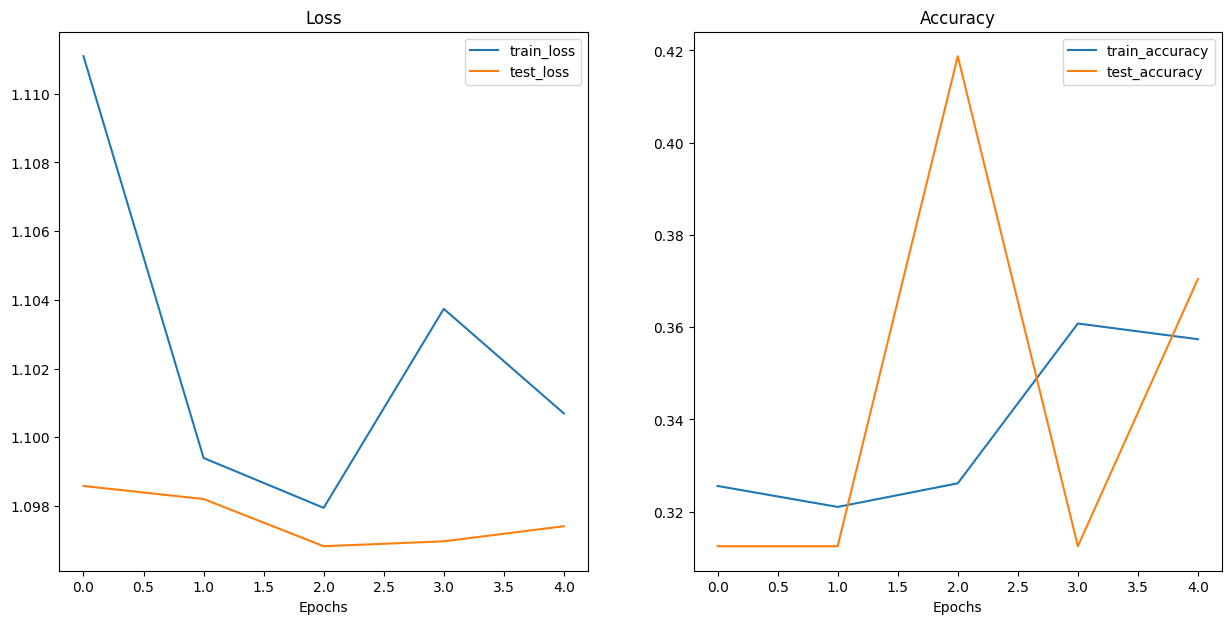

In [50]:
plot_loss_curves(model_0_results)

Woah.

Looks like things are all over the place...

But we kind of knew that because our model's print out results during training didn't show much promise.

You could try training the model for longer and see what happens when you plot a loss curve over a longer time horizon.

##  What should an ideal loss curve look like?

Looking at training and test loss curves is a great way to see if your model is **overfitting**.

An overfitting model is one that performs better (often by a considerable margin) on the training set than the validation/test set.

If your training loss is far lower than your test loss, your model is **overfitting**.

As in, it's learning the patterns in the training too well and those patterns aren't generalizing to the test data.

The other side is when your training and test loss are not as low as you'd like, this is considered **underfitting**.

The ideal position for a training and test loss curve is for them to line up closely with each other.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="different training and test loss curves illustrating overfitting, underfitting and the ideal loss curves" width="800"/>

*Left: If your training and test loss curves aren't as low as you'd like, this is considered **underfitting**. *Middle:* When your test/validation loss is higher than your training loss this is considered **overfitting**. *Right:* The ideal scenario is when your training and test loss curves line up over time. This means your model is generalizing well. There are more combinations and different things loss curves can do, for more on these, see Google's [Interpreting Loss Curves guide](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic).*

###  How to deal with overfitting

Since the main problem with overfitting is that you're model is fitting the training data *too well*, you'll want to use techniques to "reign it in".

A common technique of preventing overfitting is known as [**regularization**](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html).

I like to think of this as "making our models more regular", as in, capable of fitting *more* kinds of data.

Let's discuss a few methods to prevent overfitting.

| **Method to prevent overfitting** | **What is it?** |
| ----- | ----- |
| **Get more data** | Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples. | 
| **Simplify your model** | If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer. | 
| **Use data augmentation** | [**Data augmentation**](https://developers.google.com/machine-learning/glossary#data-augmentation) manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data. |
| **Use transfer learning** | [**Transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning) involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images. |
| **Use dropout layers** | Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for more. | 
| **Use learning rate decay** | The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to [**convergence**](https://developers.google.com/machine-learning/glossary#convergence), the smaller you'll want your weight updates to be.  |
| **Use early stopping** | [**Early stopping**](https://developers.google.com/machine-learning/glossary#early_stopping) stops model training *before* it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior). |

There are more methods for dealing with overfitting but these are some of the main ones.

As you start to build more and more deep models, you'll find because deep learnings are *so good* at learning patterns in data, dealing with overfitting is one of the primary problems of deep learning.

###  How to deal with underfitting 

When a model is [**underfitting**](https://developers.google.com/machine-learning/glossary#underfitting) it is considered to have poor predictive power on the training and test sets.

In essence, an underfitting model will fail to reduce the loss values to a desired level.

Right now, looking at our current loss curves, I'd considered our `TinyVGG` model, `model_0`, to be underfitting the data.

The main idea behind dealing with underfitting is to *increase* your model's predictive power.

There are several ways to do this.

| **Method to prevent underfitting** | **What is it?** |
| ----- | ----- |
| **Add more layers/units to your model** | If your model is underfitting, it may not have enough capability to *learn* the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers. | 
| **Tweak the learning rate** | Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens. |
| **Use transfer learning** | Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem. |
| **Train for longer** | Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance. |
| **Use less regularization** | Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help your model fit the data better. |

###  The balance between overfitting and underfitting

None of the methods discussed above are silver bullets, meaning, they don't always work.

And preventing overfitting and underfitting is possibly the most active area of machine learning research.

Since everone wants their models to fit better (less underfitting) but not so good they don't generalize well and perform in the real world (less overfitting).

There's a fine line between overfitting and underfitting.

Because too much of each can cause the other.

Transfer learning is perhaps one of the most powerful techniques when it comes to dealing with both overfitting and underfitting on your own problems.

Rather than handcraft different overfitting and underfitting techniques, transfer learning enables you to take an already working model in a similar problem space to yours (say one from [paperswithcode.com/sota](https://paperswithcode.com/sota) or [Hugging Face models](https://huggingface.co/models)) and apply it to your own dataset.

We'll see the power of transfer learning in a later notebook.

##  Model 1: TinyVGG with Data Augmentation

Time to try out another model!

This time, let's load in the data and use **data augmentation** to see if it improves our results in anyway.

First, we'll compose a training transform to include `transforms.TrivialAugmentWide()` as well as resize and turn our images into tensors.

We'll do the same for a testing transform except without the data augmentation.

###  Create transform with data augmentation

In [51]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor() 
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Wonderful!

Now let's turn our images into `Dataset`'s using `torchvision.datasets.ImageFolder()` and then into `DataLoader`'s with `torch.utils.data.DataLoader()`.

###  Create train and test `Dataset`'s and `DataLoader`'s

We'll make sure the train `Dataset` uses the `train_transform_trivial_augment` and the test `Dataset` uses the `test_transform`.

In [52]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 150
     Root location: data\food\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 150
     Root location: data\food\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

And we'll make `DataLoader`'s with a `batch_size=32` and with `num_workers` set to the number of CPUs available on our machine (we can get this using Python's `os.cpu_count()`).

In [53]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False, 
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x25e808af980>,
 <torch.utils.data.dataloader.DataLoader at 0x25eee1b8f50>)

###  Construct and train Model 1

Data loaded!

Now to build our next model, `model_1`, we can reuse our `TinyVGG` class from before. 

We'll make sure to send it to the target device.

In [54]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

Model ready!

Time to train!

Since we've already got functions for the training loop (`train_step()`) and testing loop (`test_step()`) and a function to put them together in `train()`, let's reuse those.

We'll use the same setup as `model_0` with only the `train_dataloader` parameter varying:
* Train for 5 epochs.
* Use `train_dataloader=train_dataloader_augmented` as the training data in `train()`.
* Use `torch.nn.CrossEntropyLoss()` as the loss function (since we're working with multi-class classification).
* Use `torch.optim.Adam()` with `lr=0.001` as the learning rate as the optimizer.                                                          

In [55]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_1
model_1_results = train(model=model_1, 
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1147 | train_acc: 0.3142 | test_loss: 1.1037 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.0975 | train_acc: 0.3602 | test_loss: 1.1006 | test_acc: 0.3125
Epoch: 3 | train_loss: 1.1015 | train_acc: 0.3352 | test_loss: 1.1015 | test_acc: 0.3125
Epoch: 4 | train_loss: 1.1041 | train_acc: 0.3352 | test_loss: 1.1010 | test_acc: 0.3125
Epoch: 5 | train_loss: 1.0999 | train_acc: 0.3295 | test_loss: 1.0977 | test_acc: 0.3125
Total training time: 84.917 seconds


Hmm...

It doesn't look like our model performed very well again.

Let's check out its loss curves.

###  Plot the loss curves of Model 1

Since we've got the results of `model_1` saved in a results dictionary, `model_1_results`, we can plot them using `plot_loss_curves()`.

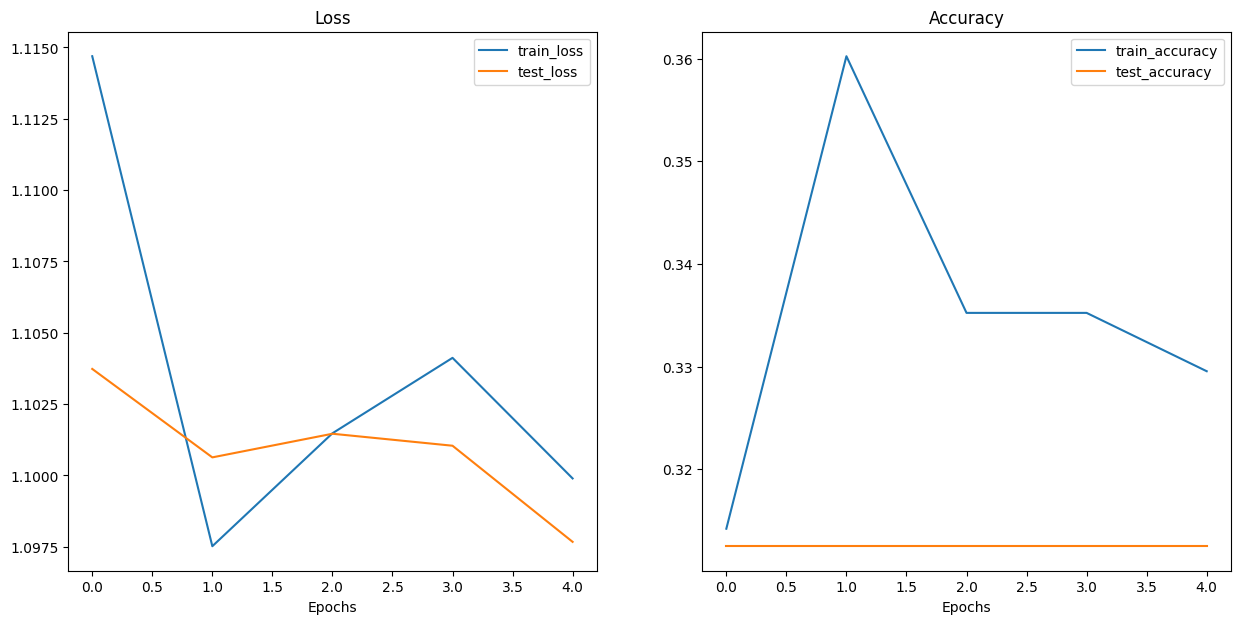

In [56]:
plot_loss_curves(model_1_results)

Wow...

These don't look very good either...

Is our model **underfitting** or **overfitting**?

Or both?

Ideally we'd like it have higher accuracy and lower loss right?

What are some methods you could try to use to achieve these?

##  Compare model results

Even though our models our performing quite poorly, we can still write code to compare them.

Let's first turn our model results in pandas DataFrames.

In [57]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.111090,0.325568,1.098584,0.312500
1,1.099399,0.321023,1.098204,0.312500
2,1.097947,0.326136,1.096831,0.418750
3,1.103738,0.360795,1.096973,0.312500
4,1.100695,0.357386,1.097414,0.370455


And now we can write some plotting code using `matplotlib` to visualize the results of `model_0` and `model_1` together.

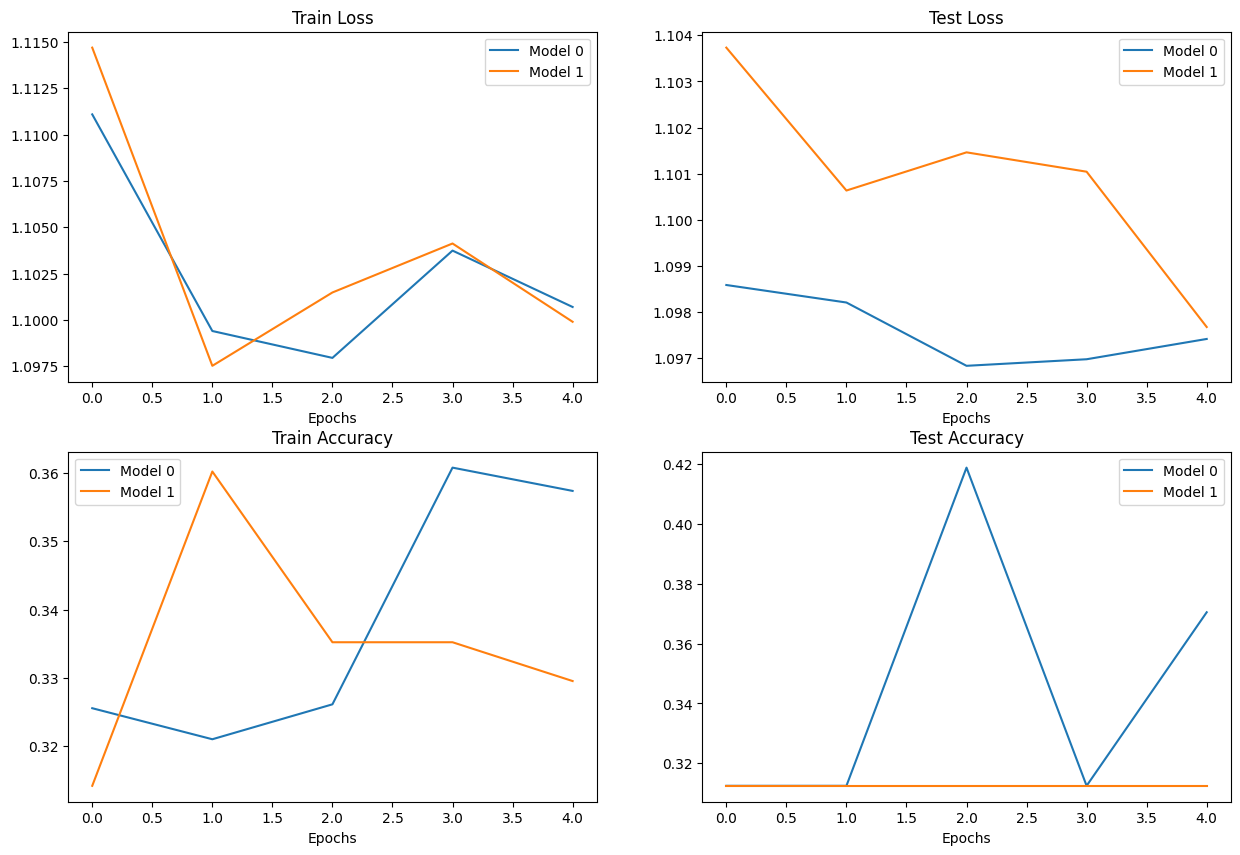

In [58]:
# Setup a plot 
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

It looks like our models both performed equally poorly and were kind of sporadic (the metrics go up and down sharply).

If you built `model_2`, what would you do differently to try and improve performance?

## . Make a prediction on a custom image

If you've trained a model on a certain dataset, chances are you'd like to make a prediction on on your own custom data.

In our case, since we've trained a model on pizza, steak and sushi images, how could we use our model to make a prediction on one of our own images?

To do so, we can load an image and then **preprocess it in a way that matches the type of data our model was trained on**.

In other words, we'll have to convert our own custom image to a tensor and make sure it's in the right datatype before passing it to our model.

Let's start by downloading a custom image.

Since our model predicts whether an image contains pizza, steak or sushi, let's download a photo of [my Dad giving two thumbs up to a big pizza from the Learn PyTorch for Deep Learning GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg).

We download the image using Python's `requests` module.

> **Note:** If you're using Google Colab, you can also upload an image to the current session by going to the left hand side menu -> Files -> Upload to session storage. Beware though, this image will delete when your Google Colab session ends.


In [70]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "0d81432b55.jpg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data\0d81432b55.jpg already exists, skipping download.


###  Loading in a custom image with PyTorch

Excellent!

Looks like we've got a custom image downloaded and ready to go at `data/04-pizza-dad.jpeg`. 

Time to load it in.

PyTorch's `torchvision` has several input and output ("IO" or "io" for short) methods for reading and writing images and video in [`torchvision.io`](https://pytorch.org/vision/stable/io.html).

Since we want to load in an image, we'll use [`torchvision.io.read_image()`](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image).

This method will read a JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale `torch.Tensor` with values of datatype `uint8` in range `[0, 255]`.

Let's try it out.

In [71]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[186, 186, 187,  ..., 215, 219, 223],
         [186, 186, 187,  ..., 220, 223, 227],
         [186, 186, 187,  ..., 223, 225, 229],
         ...,
         [180, 175, 176,  ..., 141, 137, 151],
         [182, 176, 179,  ..., 140, 135, 145],
         [187, 181, 183,  ..., 139, 135, 141]],

        [[171, 171, 172,  ..., 137, 141, 146],
         [171, 171, 172,  ..., 143, 146, 148],
         [171, 171, 172,  ..., 145, 147, 148],
         ...,
         [170, 165, 166,  ..., 103,  99, 113],
         [176, 170, 170,  ..., 103,  98, 108],
         [181, 175, 174,  ..., 102,  98, 104]],

        [[132, 132, 133,  ..., 124, 128, 130],
         [132, 132, 133,  ..., 127, 130, 131],
         [132, 132, 133,  ..., 125, 127, 127],
         ...,
         [134, 129, 130,  ...,  84,  80,  94],
         [142, 136, 137,  ...,  84,  79,  89],
         [147, 141, 141,  ...,  83,  79,  85]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 275, 183])

Custom image dtype

Nice! Looks like our image is in tensor format, however, is this image format compatible with our model?

Our `custom_image` tensor is of datatype `torch.uint8` and its values are between `[0, 255]`.

But our model takes image tensors of datatype `torch.float32` and with values between `[0, 1]`.

So before we use our custom image with our model, **we'll need to convert it to the same format as the data our model is trained on**.

If we don't do this, our model will error.

In [72]:
# Try to make a prediction on image in uint8 format (this will error)
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

If we try to make a prediction on an image in a different datatype to what our model was trained on, we get an error like the following:

> `RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same`

Let's fix this by converting our custom image to the same datatype as what our model was trained on (`torch.float32`).

In [73]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.7294, 0.7294, 0.7333,  ..., 0.8431, 0.8588, 0.8745],
         [0.7294, 0.7294, 0.7333,  ..., 0.8627, 0.8745, 0.8902],
         [0.7294, 0.7294, 0.7333,  ..., 0.8745, 0.8824, 0.8980],
         ...,
         [0.7059, 0.6863, 0.6902,  ..., 0.5529, 0.5373, 0.5922],
         [0.7137, 0.6902, 0.7020,  ..., 0.5490, 0.5294, 0.5686],
         [0.7333, 0.7098, 0.7176,  ..., 0.5451, 0.5294, 0.5529]],

        [[0.6706, 0.6706, 0.6745,  ..., 0.5373, 0.5529, 0.5725],
         [0.6706, 0.6706, 0.6745,  ..., 0.5608, 0.5725, 0.5804],
         [0.6706, 0.6706, 0.6745,  ..., 0.5686, 0.5765, 0.5804],
         ...,
         [0.6667, 0.6471, 0.6510,  ..., 0.4039, 0.3882, 0.4431],
         [0.6902, 0.6667, 0.6667,  ..., 0.4039, 0.3843, 0.4235],
         [0.7098, 0.6863, 0.6824,  ..., 0.4000, 0.3843, 0.4078]],

        [[0.5176, 0.5176, 0.5216,  ..., 0.4863, 0.5020, 0.5098],
         [0.5176, 0.5176, 0.5216,  ..., 0.4980, 0.5098, 0.5137],
         [0.5176, 0.5176, 0.5216,  ..

###  Predicting on custom images with a trained PyTorch model

Beautiful, it looks like our image data is now in the same format our model was trained on.

Except for one thing...

It's `shape`.

Our model was trained on images with shape `[3, 64, 64]`, whereas our custom image is currently `[3, 4032, 3024]`. 

How could we make sure our custom image is the same shape as the images our model was trained on?

Are there any `torchvision.transforms` that could help?

Before we answer that question, let's plot the image with `matplotlib` to make sure it looks okay, remember we'll have to permute the dimensions from `CHW` to `HWC` to suit `matplotlib`'s requirements.

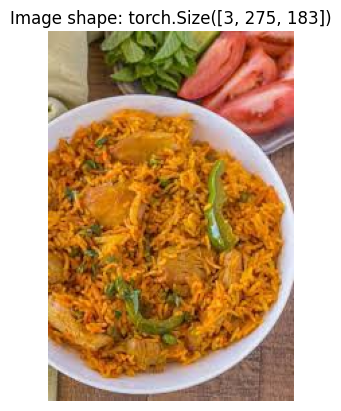

In [74]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

Two thumbs up!

Now how could we get our image to be the same size as the images our model was trained on?

One way to do so is with `torchvision.transforms.Resize()`.

Let's compose a transform pipeline to do so.

In [75]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 275, 183])
New shape: torch.Size([3, 64, 64])


Woohoo!

Let's finally make a prediction on our own custom image.

In [76]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper_CUDA___slow_conv2d_forward)

Oh my goodness...

Despite our preparations our custom image and model are on different devices.

And we get the error:

> `RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)`

Let's fix that by putting our `custom_image_transformed` on the target device.

In [77]:
model_1.eval()
with torch.inference_mode():
    custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

What now?

It looks like we're getting a shape error.

Why might this be?

We converted our custom image to be the same size as the images our model was trained on...

Oh wait...

There's one dimension we forgot about.

The batch size.

Our model expects image tensors with a batch size dimension at the start (`NCHW` where `N` is the batch size).

Except our custom image is currently only `CHW`. 

We can add a batch size dimension using `torch.unsqueeze(dim=0)` to add an extra dimension our image and *finally* make a prediction. 

Essentially we'll be telling our model to predict on a single image (an image with a `batch_size` of 1).

In [78]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)
    
    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")
    
    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


Yes!!!

It looks like it worked!

> **Note:** What we've just gone through are three of the classical and most common deep learning and PyTorch issues:
> 1. **Wrong datatypes** - our model expects `torch.float32` where our original custom image was `uint8`.
> 2. **Wrong device** - our model was on the target `device` (in our case, the GPU) whereas our target data hadn't been moved to the target `device` yet.
> 3. **Wrong shapes** - our model expected an input image of shape `[N, C, H, W]` or `[batch_size, color_channels, height, width]` whereas our custom image tensor was of shape `[color_channels, height, width]`.
>
> Keep in mind, these errors aren't just for predicting on custom images. 
>
> They will be present with almost every kind of data type (text, audio, structured data) and problem you work with.

Now let's take a look at our model's predictions.

In [79]:
custom_image_pred

tensor([[0.0133, 0.0921, 0.0612]], device='cuda:0')

Alright, these are still in *logit form* (the raw outputs of a model are called logits).

Let's convert them from logits -> prediction probabilities -> prediction labels.

In [80]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[0.0133, 0.0921, 0.0612]], device='cuda:0')
Prediction probabilities: tensor([[0.3194, 0.3456, 0.3350]], device='cuda:0')
Prediction label: tensor([1], device='cuda:0')


Alright!

Looking good.

But of course our prediction label is still in index/tensor form.

We can convert it to a string class name prediction by indexing on the `class_names` list.

In [81]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'butter_chicken'

Wow.

It looks like the model gets the prediction right, even though it was performing poorly based on our evaluation metrics.

> **Note:** The model in its current form will predict "pizza", "steak" or "sushi" no matter what image it's given. If you wanted your model to predict on a different class, you'd have to train it to do so.

But if we check the `custom_image_pred_probs`, we'll notice that the model gives almost equal weight (the values are similar) to every class.

In [82]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[0.3194, 0.3456, 0.3350]], device='cuda:0')

Having prediction probabilities this similar could mean a couple of things:
1. The model is trying to predict all three classes at the same time (there may be an image containing pizza, steak and sushi).
2. The model doesn't really know what it wants to predict and is in turn just assigning similar values to each of the classes.

Our case is number 2, since our model is poorly trained, it is basically *guessing* the prediction.

###  Putting custom image prediction together: building a function

Doing all of the above steps every time you'd like to make a prediction on a custom image would quickly become tedious.

So let's put them all together in a function we can easily use over and over again.

Specifically, let's make a function that:
1. Takes in a target image path and converts to the right datatype for our model (`torch.float32`).
2. Makes sure the target image pixel values are in the range `[0, 1]`.
3. Transforms the target image if necessary.
4. Makes sure the model is on the target device.
5. Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model).
6. Converts the model's output logits to prediction probabilities.
7. Converts the prediction probabilities to prediction labels.
8. Plots the target image alongside the model prediction and prediction probability.

A fair few steps but we've got this!

In [83]:
def pred_and_plot_image(model: torch.nn.Module, 
                        image_path: str, 
                        class_names: List[str] = None, 
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""
    
    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
    
    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255. 
    
    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)
    
    # 4. Make sure the model is on the target device
    model.to(device)
    
    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)
    
        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))
        
    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    
    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else: 
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

What a nice looking function, let's test it out.

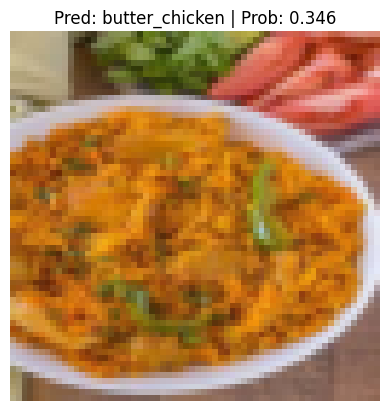

In [84]:
# Pred on our custom image
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

## Main takeaways

We've covered a fair bit in this module.

Let's summarise it with a few dot points.

* PyTorch has many in-built functions to deal with all kinds of data, from vision to text to audio to recommendation systems.
* If PyTorch's built-in data loading functions don't suit your requirements, you can write code to create your own custom datasets by subclassing `torch.utils.data.Dataset`.
* `torch.utils.data.DataLoader`'s in PyTorch help turn your `Dataset`'s into iterables that can be used when training and testing a model.
* A lot of machine learning is dealing with the balance between **overfitting** and **underfitting** (we discussed different methods for each above, so a good exercise would be to research more and writing code to try out the different techniques).
* Predicting on your own custom data with a trained model is possible, as long as you format the data into a similar format to what the model was trained on. Make sure you take care of the three big PyTorch and deep learning errors:
    1. **Wrong datatypes** - Your model expected `torch.float32` when your data is `torch.uint8`.
    2. **Wrong data shapes** - Your model expected `[batch_size, color_channels, height, width]` when your data is `[color_channels, height, width]`.
    3. **Wrong devices** - Your model is on the GPU but your data is on the CPU. 

# https://www.kaggle.com/datasets/iamsouravbanerjee/indian-food-images-dataset?resource=download 

# Join the Pytorch PLAYLIST FROM 0 - MASTERY 

# https://www.youtube.com/@suruj0001/playlists 